In [1]:
import os
import random
import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as F

from utils.data import load_data
from utils.validators import pyspark_info

spark = SparkSession.builder \
    .appName("DataFrame Example") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/28 17:48:31 WARN Utils: Your hostname, Nicholass-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.45 instead (on interface en0)
25/06/28 17:48:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/28 17:48:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from configs.data import gold_data_dirs, model_registry_dir
from utils.validators import build_partition_name
from pyspark.ml import PipelineModel

date_str = '2024-07-01'

print(f"\nLoading Champion model from model registry...")
model_path = os.path.join(model_registry_dir, 'best_model')
model = PipelineModel.load(model_path)

# Load data for inference
print(f"Loading data for inference on {date_str}...")
partition = build_partition_name('gold', 'feature_store', date_str, 'parquet')
df = load_data(spark, gold_data_dirs['feature_store'], partition)

pyspark_info(df)
df.show(5, truncate=False)

# Perform inference
print(f"Running inference on data for {date_str}...")
predictions = model.transform(df)

pyspark_info(predictions)
predictions.show(5, truncate=False)



Loading Champion model from model registry...
Loading data for inference on 2024-07-01...
Loaded data from datamart/gold/feature_store/gold_feature_store_2024_07_01.parquet. Row count: 505

Total entries: 505
Data columns (total 76 columns):
#   Column                                             Non-Null Count     Dtype          
--- -------------------------------------------------- ------------------ ---------------
0   Customer_ID                                        505                string         
1   snapshot_date                                      505                date           
2   Age                                                505                int            
3   Annual_Income                                      505                decimal(18,2)  
4   Monthly_Inhand_Salary                              505                decimal(18,2)  
5   Num_Bank_Accounts                                  505                int            
6   Num_Credit_Card                  

## Full Gold Level Load

In [14]:
# load and merge gold data

# create list of dates for which to load data
date_list = pd.date_range(start='2023-01-01', end='2024-12-01', freq='MS').strftime('%Y-%m-%d').tolist()

# load data for each date and merge into a single DataFrame
from scripts.ml_processing.training_data_prep import load_and_merge_data

df = load_and_merge_data(spark, date_list)


Loading and merging data from gold feature store and label store...
Loaded data from datamart/gold/feature_store/gold_feature_store_2023_01_01.parquet. Row count: 530
Loaded data from datamart/gold/label_store/gold_label_store_2023_01_01.parquet. Row count: 0
Loaded data from datamart/gold/feature_store/gold_feature_store_2023_02_01.parquet. Row count: 501
Loaded data from datamart/gold/label_store/gold_label_store_2023_02_01.parquet. Row count: 0
Loaded data from datamart/gold/feature_store/gold_feature_store_2023_03_01.parquet. Row count: 506
Loaded data from datamart/gold/label_store/gold_label_store_2023_03_01.parquet. Row count: 0
Loaded data from datamart/gold/feature_store/gold_feature_store_2023_04_01.parquet. Row count: 510
Loaded data from datamart/gold/label_store/gold_label_store_2023_04_01.parquet. Row count: 0
Loaded data from datamart/gold/feature_store/gold_feature_store_2023_05_01.parquet. Row count: 521
Loaded data from datamart/gold/label_store/gold_label_store_2023

### Occupation Analysis

In [15]:
df_occ = df
for col in df_occ.columns:
    if col.startswith('Occupation') or col.startswith('label'):
        continue
    else:
        df_occ = df_occ.drop(col)

pyspark_info(df_occ)


Total entries: 8974
Data columns (total 17 columns):
#   Column                    Non-Null Count     Dtype          
--- ------------------------- ------------------ ---------------
0   Occupation_index          8974               double         
1   Occupation_Journalist     8974               int            
2   Occupation_Lawyer         8974               int            
3   Occupation_Media_Manager  8974               int            
4   Occupation_Writer         8974               int            
5   Occupation_Developer      8974               int            
6   Occupation_Scientist      8974               int            
7   Occupation_Accountant     8974               int            
8   Occupation_Doctor         8974               int            
9   Occupation_Musician       8974               int            
10  Occupation_Engineer       8974               int            
11  Occupation_Mechanic       8974               int            
12  Occupation_Teacher        8974  

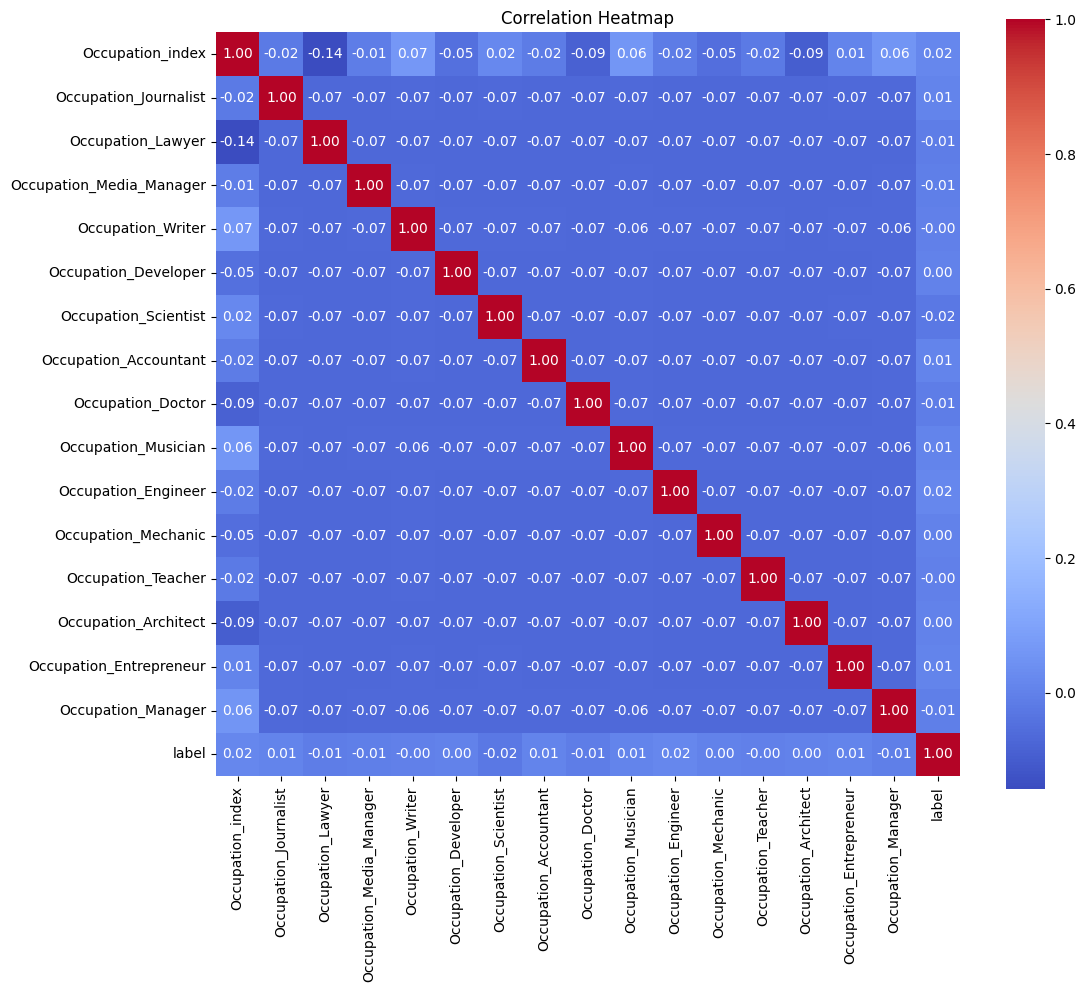

In [16]:
df_pd = df_occ.toPandas()

# Compute correlation matrix
corr_matrix = df_pd.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()

absolutely no information --> can remove I'd say

### Credit-Mix & Payment-Behaviour Analysis

In [17]:
df_cre = df
for col in df_cre.columns:
    if col.startswith('Credit_') or col.startswith('Payment_') or col.startswith('label'):
        continue
    else:
        df_cre = df_cre.drop(col)

pyspark_info(df_cre)


Total entries: 8974
Data columns (total 15 columns):
#   Column                                             Non-Null Count     Dtype          
--- -------------------------------------------------- ------------------ ---------------
0   Credit_Utilization_Ratio                           8974               decimal(12,2)  
1   Credit_History_Age                                 8974               int            
2   Payment_of_Min_Amount                              8974               boolean        
3   Credit_Mix_index                                   8974               double         
4   Credit_Mix_Standard                                8974               int            
5   Credit_Mix_Good                                    8974               int            
6   Credit_Mix_Bad                                     8974               int            
7   Payment_Behaviour_index                            8974               double         
8   Payment_Behaviour_Low_spent_Small_value_pa

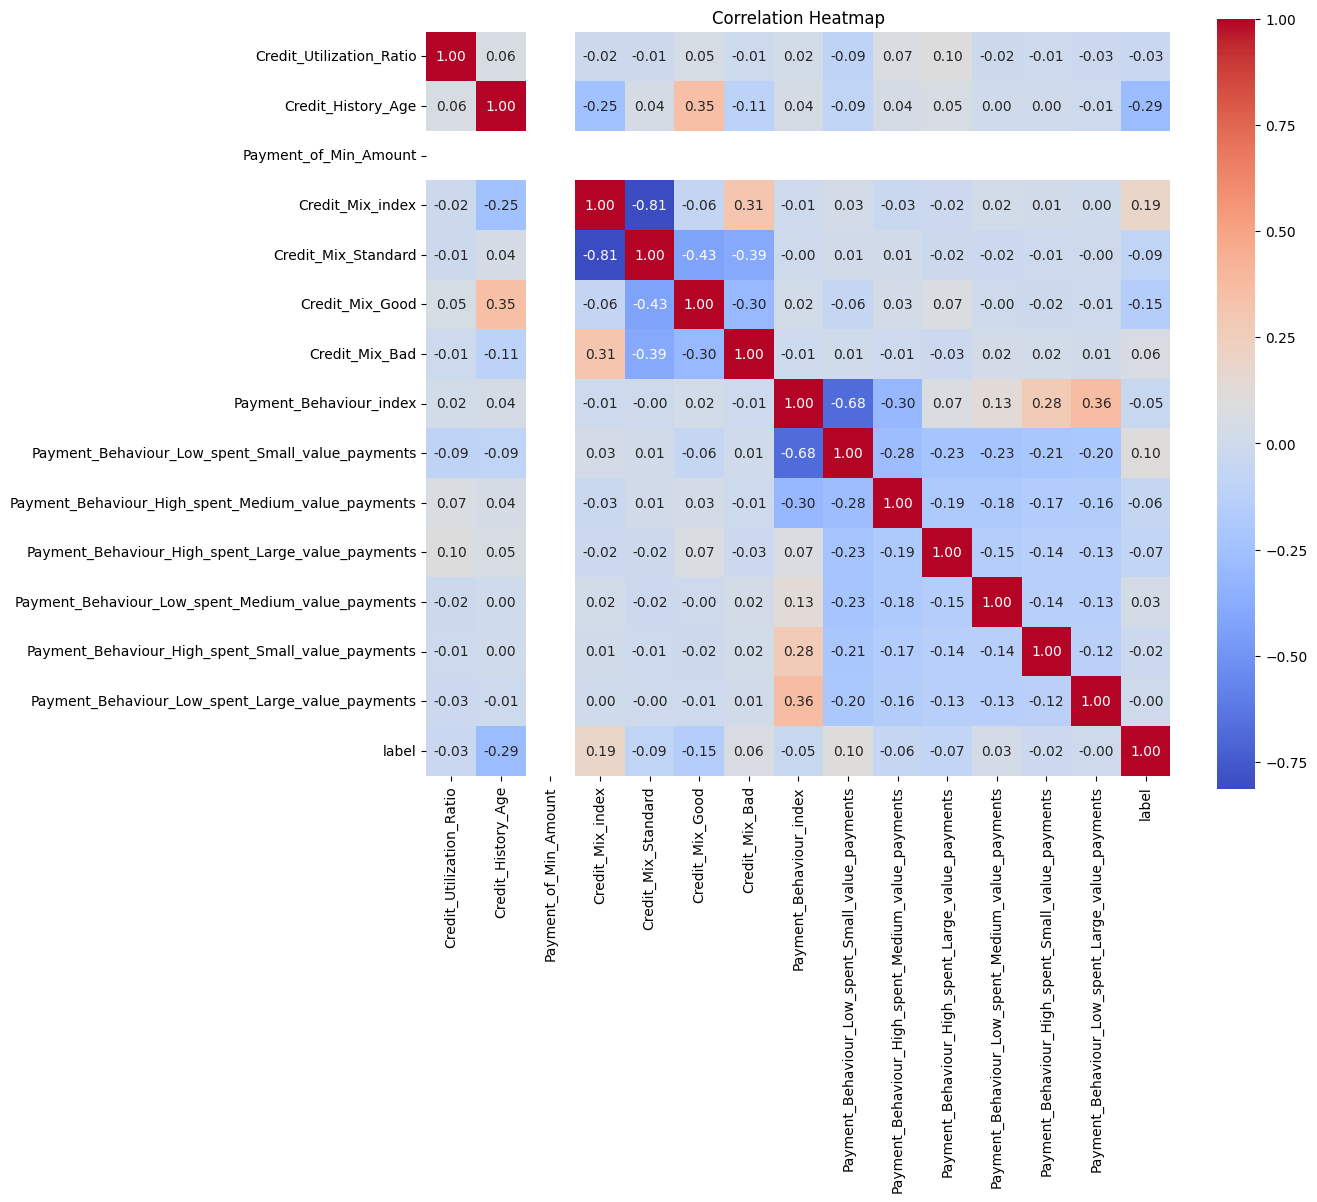

In [18]:
df_pd = df_cre.toPandas()

# Compute correlation matrix
corr_matrix = df_pd.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()

credit mix could benefit from linear encoding instead of ohe. </br>
Payment behaviour into two columns: binary high-spent, linear encoded value (1=small, 2=medium, 3=large)

## Loan Types Analysis

In [19]:
df_ln = df
for col in df_ln.columns:
    if col.startswith('LoanType') or col.startswith('Num_of_') or col.startswith('label'):
        continue
    else:
        df_ln = df_ln.drop(col)
pyspark_info(df_ln)



Total entries: 8974
Data columns (total 12 columns):
#   Column                                 Non-Null Count     Dtype          
--- -------------------------------------- ------------------ ---------------
0   Num_of_Loan                            8974               int            
1   Num_of_Delayed_Payment                 8974               int            
2   LoanType_Personal_Loan_Count           8974               int            
3   LoanType_Student_Loan_Count            8974               int            
4   LoanType_Payday_Loan_Count             8974               int            
5   LoanType_Auto_Loan_Count               8974               int            
6   LoanType_Home_Equity_Loan_Count        8974               int            
7   LoanType_Mortgage_Loan_Count           8974               int            
8   LoanType_Credit_Builder_Loan_Count     8974               int            
9   LoanType_Debt_Consolidation_Loan_Count 8974               int            
10  LoanTy

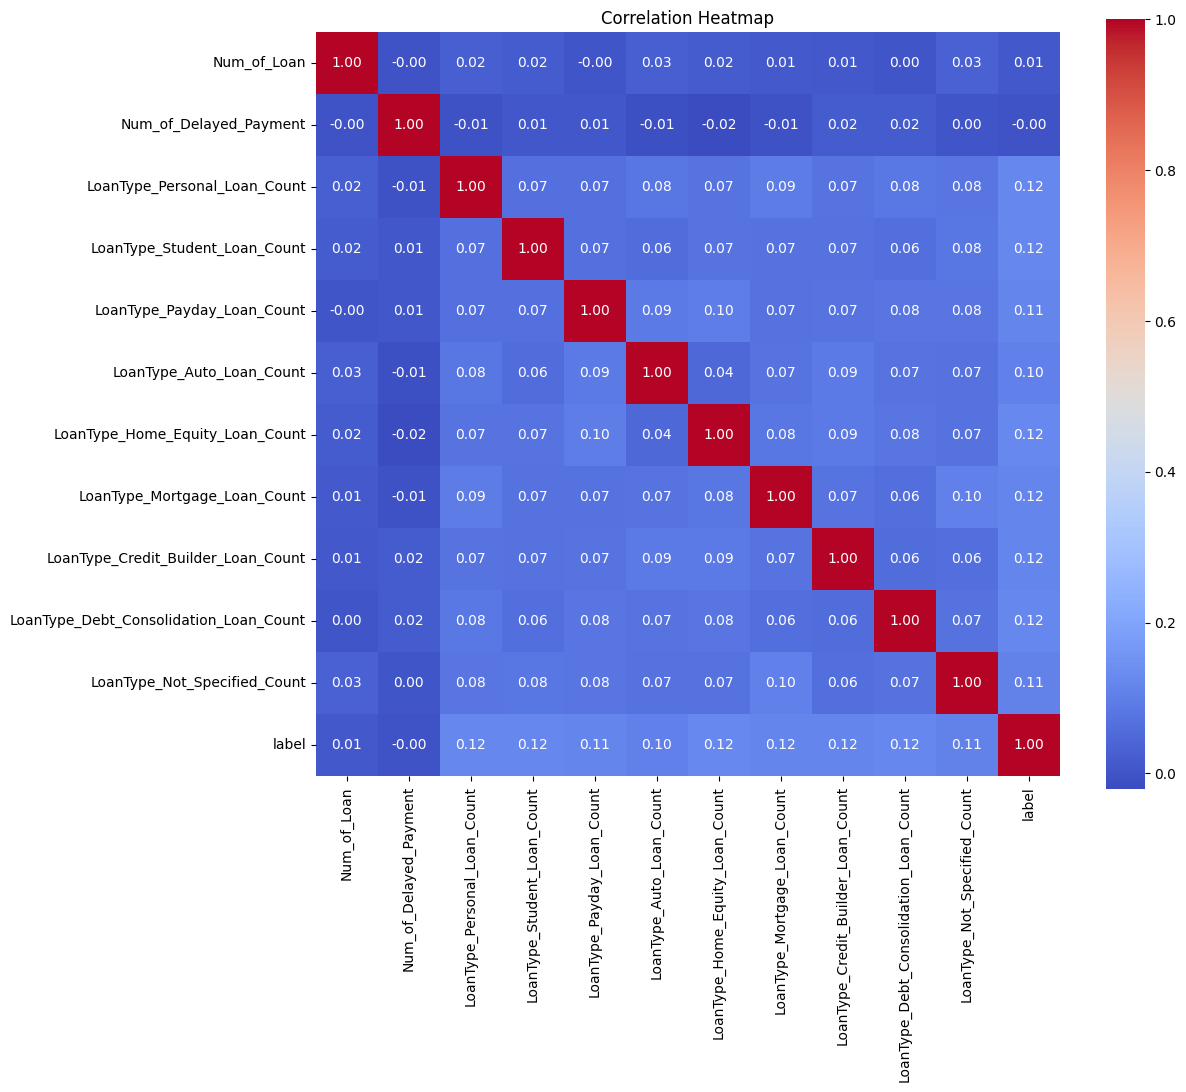

In [20]:
df_pd = df_ln.toPandas()

# Compute correlation matrix
corr_matrix = df_pd.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()

maybe consolidate types into three larger groups (personal, home, credit)

## Clickstream Analysis

In [21]:
df_fe = df
for col in df_fe.columns:
    if col.startswith('fe_') or col.startswith('label'):
        continue
    else:
        df_fe = df_fe.drop(col)
pyspark_info(df_fe)



Total entries: 8974
Data columns (total 21 columns):
#   Column                    Non-Null Count     Dtype          
--- ------------------------- ------------------ ---------------
0   fe_1_avg                  8974               double         
1   fe_2_avg                  8974               double         
2   fe_3_avg                  8974               double         
3   fe_4_avg                  8974               double         
4   fe_5_avg                  8974               double         
5   fe_6_avg                  8974               double         
6   fe_7_avg                  8974               double         
7   fe_8_avg                  8974               double         
8   fe_9_avg                  8974               double         
9   fe_10_avg                 8974               double         
10  fe_11_avg                 8974               double         
11  fe_12_avg                 8974               double         
12  fe_13_avg                 8974  

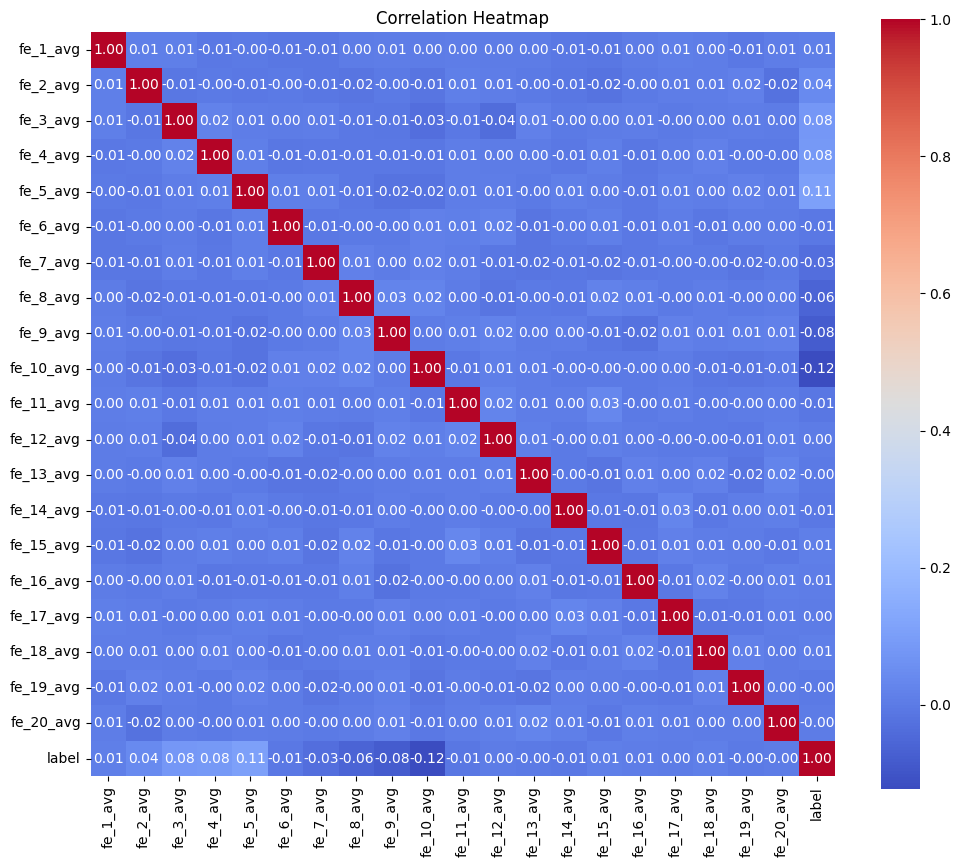

25/06/27 03:58:42 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:131)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:700)
	at org.apache.spark.storage.BlockManagerMasterE

In [22]:
df_pd = df_fe.toPandas()

# Compute correlation matrix
corr_matrix = df_pd.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()

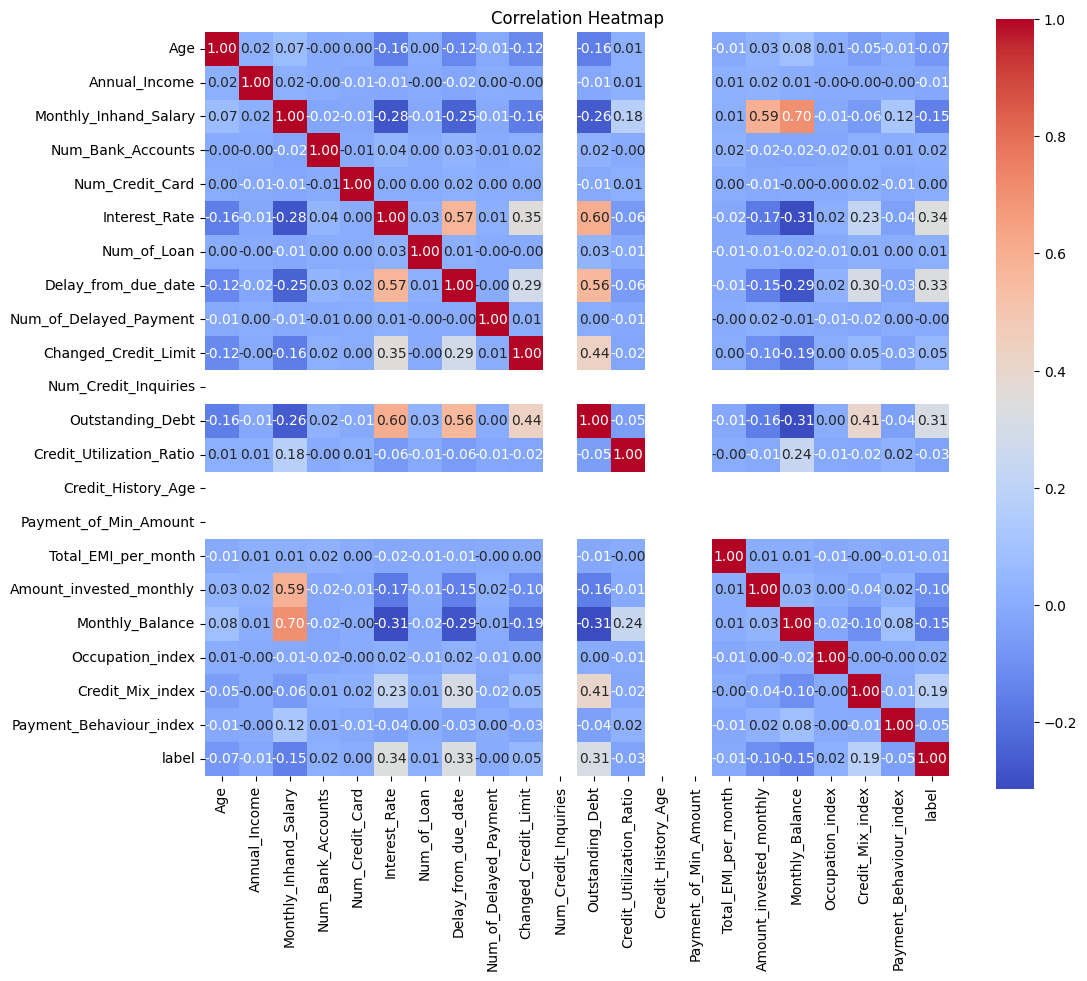

In [9]:
import seaborn as sns

import matplotlib.pyplot as plt

# Select only numeric columns for correlation
df_pd = df.drop('Customer_ID', 'snapshot_date').toPandas()

# Compute correlation matrix
corr_matrix = df_pd.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()

In [8]:
for col in df.columns:
    if col.startswith('Occupation') or col.startswith('LoanType') or col.startswith('Payment_Behaviour') or col.startswith('Credit_Mix'):
        if col.endswith('_index'):
            continue
        else:
            df = df.drop(col)

pyspark_info(df)


Total entries: 8974
Data columns (total 44 columns):
#   Column                    Non-Null Count     Dtype          
--- ------------------------- ------------------ ---------------
0   Customer_ID               8974               string         
1   snapshot_date             8974               date           
2   Age                       8974               int            
3   Annual_Income             8974               decimal(18,2)  
4   Monthly_Inhand_Salary     8974               decimal(18,2)  
5   Num_Bank_Accounts         8974               int            
6   Num_Credit_Card           8974               int            
7   Interest_Rate             8974               int            
8   Num_of_Loan               8974               int            
9   Delay_from_due_date       8974               int            
10  Num_of_Delayed_Payment    8974               int            
11  Changed_Credit_Limit      8974               double         
12  Num_Credit_Inquiries      8974  

In [12]:
from configs.data import training_data_dir

# Load all datasets from the training directory
print(f"\nLoading datasets from {training_data_dir}...")
datasets = {}
for sets in os.listdir(training_data_dir):
    if sets.endswith('.parquet'):
        dataset_name = sets.split('.')[0]  # Remove the .parquet extension
        datasets[dataset_name] = spark.read.parquet(os.path.join(training_data_dir, sets))
    else:
        print(f"Skipping unsupported file format: {sets}")

for name, df in datasets.items():
    print(f"Dataset: {name} with {df.count()} rows.")




Loading datasets from datamart/training/...
Dataset: test with 1149 rows.
Dataset: oot_1 with 513 rows.
Dataset: oot_3 with 498 rows.
Dataset: oot_2 with 491 rows.
Dataset: validation with 1084 rows.
Dataset: training with 5239 rows.


In [10]:
# Prepare train, validation and test datasets for Models
train_df = datasets['training']
validation_df = datasets['validation']
test_df = datasets['test']

## GBTClassifier

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import random
import tqdm

# Assemble features into a single vector column
assembler = VectorAssembler(
    inputCols=[col for col in train_df.columns if col not in ['Customer_ID', 'label', 'snapshot_date']], 
    outputCol='features'
)

# Define the GBT Classifier    
gbt = GBTClassifier(labelCol='label', featuresCol='features', seed=42)

# Define possible values
maxDepths = [3, 4, 5, 6, 7, 8]
maxIters = [10, 20, 30, 40, 50]
stepSizes = [0.05, 0.1, 0.2]
minInstancesPerNode = [1, 2, 5, 10]
minInfoGain = [0.0, 0.01, 0.05]
subsamplingRates = [0.6, 0.8, 1.0]
featureSubsetStrategies = ['auto', 'sqrt', 'log2', 'onethird']

# Randomly sample combinations
random_grid = [
    {
        gbt.maxDepth: random.choice(maxDepths),
        gbt.maxIter: random.choice(maxIters),
        gbt.stepSize: random.choice(stepSizes),
        gbt.minInstancesPerNode: random.choice(minInstancesPerNode),
        gbt.minInfoGain: random.choice(minInfoGain),
        gbt.subsamplingRate: random.choice(subsamplingRates),
        gbt.featureSubsetStrategy: random.choice(featureSubsetStrategies)
    }
    for _ in range(100)  # x random combinations
]

# Convert to ParamGridBuilder format
paramGrid = ParamGridBuilder()
for params in random_grid:
    paramGrid = paramGrid.addGrid(gbt.maxDepth, [params[gbt.maxDepth]]) \
                        .addGrid(gbt.maxIter, [params[gbt.maxIter]]) \
                        .addGrid(gbt.stepSize, [params[gbt.stepSize]]) \
                        .addGrid(gbt.minInstancesPerNode, [params[gbt.minInstancesPerNode]]) \
                        .addGrid(gbt.minInfoGain, [params[gbt.minInfoGain]]) \
                        .addGrid(gbt.subsamplingRate, [params[gbt.subsamplingRate]]) \
                        .addGrid(gbt.featureSubsetStrategy, [params[gbt.featureSubsetStrategy]])
paramGrid = paramGrid.build()


# Prepare pipeline
pipeline = Pipeline(stages=[assembler, gbt])
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')

# Fit and tune the model
print("\nStarting model training and hyperparameter tuning...")
results = []
for params in tqdm.tqdm(random_grid, desc="Training models", unit="model"):
    # Set parameters for this run
    for param, value in params.items():
        gbt._set(**{param.name: value})
    
    # Fit pipeline on train_df
    model = pipeline.fit(train_df)
    
    # Evaluate on train and validation data
    train_predictions = model.transform(train_df)
    train_auc = evaluator.evaluate(train_predictions)
    val_predictions = model.transform(validation_df)
    val_auc = evaluator.evaluate(val_predictions)
    
    # Store results
    results.append({
        'params': {param.name: value for param, value in params.items()},
        'metrics': {'train_auc': train_auc, 'val_auc': val_auc},
        'model': model
    })

# Find the best model by validation AUC & evaluating on test and OOT datasets
print("\nExtracting the best model based on validation AUC & evaluating on test & oot data...")
best_result = max(results, key=lambda x: x['metrics']['val_auc'])
best_model = best_result['model']

test_predictions = best_model.transform(test_df)
best_result['metrics']['test_auc'] = evaluator.evaluate(test_predictions)

for i in range(1, len(datasets) - 2):
    oot_df = datasets[f'oot_{i}']
    oot_predictions = best_model.transform(oot_df)
    best_result['metrics'][f'oot_{i}_auc'] = evaluator.evaluate(oot_predictions)

print("\nTraining completed. Best model parameters and metrics:")
print(best_result['params'])
print(best_result['metrics'])

# Get feature importances
importances = best_model.stages[-1].featureImportances
feature_importance_list = list(zip(assembler.getInputCols(), importances.toArray()))
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

print("\nTop features by importance:")
for name, score in feature_importance_list:
    print(f"{name}: {score:.4f}")


Starting model training and hyperparameter tuning...


Training models: 100%|██████████| 100/100 [05:12<00:00,  3.12s/model]



Extracting the best model based on validation AUC & evaluating on test & oot data...

Training completed. Best model parameters and metrics:
{'maxDepth': 3, 'maxIter': 20, 'stepSize': 0.2, 'minInstancesPerNode': 5, 'minInfoGain': 0.0, 'subsamplingRate': 0.8, 'featureSubsetStrategy': 'auto'}
{'train_auc': 0.8635848452470248, 'val_auc': 0.8349445071682677, 'test_auc': 0.8127306204295226, 'oot_1_auc': 0.7761854143730308, 'oot_2_auc': 0.7803092743043282, 'oot_3_auc': 0.8406094234929008}

Top features by importance:
Outstanding_Debt: 0.1325
Occupation_index: 0.0957
Interest_Rate: 0.0720
fe_10_avg: 0.0696
Delay_from_due_date: 0.0677
fe_5_avg: 0.0595
Num_Bank_Accounts: 0.0591
fe_3_avg: 0.0428
Num_Credit_Card: 0.0425
Payment_Behaviour_index: 0.0362
Num_of_Delayed_Payment: 0.0347
fe_9_avg: 0.0314
fe_4_avg: 0.0289
fe_2_avg: 0.0272
fe_8_avg: 0.0271
Amount_invested_monthly: 0.0210
Changed_Credit_Limit: 0.0173
Annual_Income: 0.0156
Total_EMI_per_month: 0.0143
fe_12_avg: 0.0142
fe_20_avg: 0.0140
fe

## Logistic Regression

In [12]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
import random
import tqdm

# Assemble features into a single vector column
assembler = VectorAssembler(
    inputCols=[col for col in train_df.columns if col not in ['Customer_ID', 'label', 'snapshot_date']], 
    outputCol='features'
)

# Define the Logistic Regression model
lr = LogisticRegression(labelCol='label', featuresCol='features', maxIter=100, elasticNetParam=0.0)

# Define possible hyperparameter values
regParams = [0.01, 0.02, 0.05, 0.1, 0.2]
elasticNetParams = [0.0, 0.5, 1.0]
maxIters = [100, 200, 500, 1000]
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

# Randomly sample combinations
random_grid_lr = [
    {
        lr.regParam: random.choice(regParams),
        lr.elasticNetParam: random.choice(elasticNetParams),
        lr.maxIter: random.choice(maxIters),
        lr.threshold: random.choice(thresholds)
    }
    for _ in range(100)  # x random combinations
]

# Prepare pipeline
pipeline_lr = Pipeline(stages=[assembler, lr])
evaluator_lr = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')

# Fit and tune the model
print("\nStarting Logistic Regression model training and hyperparameter tuning...")
results_lr = []
for params in tqdm.tqdm(random_grid_lr, desc="Training LR models", unit="model"):
    # Set parameters for this run
    for param, value in params.items():
        lr._set(**{param.name: value})
    
    # Fit pipeline on train_df
    model = pipeline_lr.fit(train_df)
    
    # Evaluate on train and validation data
    train_predictions = model.transform(train_df)
    train_auc = evaluator_lr.evaluate(train_predictions)
    val_predictions = model.transform(validation_df)
    val_auc = evaluator_lr.evaluate(val_predictions)
    
    # Store results
    results_lr.append({
        'params': {param.name: value for param, value in params.items()},
        'metrics': {'train_auc': train_auc, 'val_auc': val_auc},
        'model': model
    })

# Find the best model by validation AUC & evaluating on test and OOT datasets
print("\nExtracting the best Logistic Regression model based on validation AUC & evaluating on test & oot data...")
best_result_lr = max(results_lr, key=lambda x: x['metrics']['val_auc'])
best_model_lr = best_result_lr['model']

test_predictions_lr = best_model_lr.transform(test_df)
best_result_lr['metrics']['test_auc'] = evaluator_lr.evaluate(test_predictions_lr)

for i in range(1, len(datasets) - 2):
    oot_df = datasets[f'oot_{i}']
    oot_predictions_lr = best_model_lr.transform(oot_df)
    best_result_lr['metrics'][f'oot_{i}_auc'] = evaluator_lr.evaluate(oot_predictions_lr)

print("\nLogistic Regression training completed. Best model parameters and metrics:")
print(best_result_lr['params'])
print(best_result_lr['metrics'])

# Get feature importances (coefficients)
lr_stage = best_model_lr.stages[-1]
coefficients = lr_stage.coefficients.toArray()
feature_names = assembler.getInputCols()
feature_importance_list_lr = list(zip(feature_names, coefficients))
feature_importance_list_lr.sort(key=lambda x: abs(x[1]), reverse=True)

print("\nTop features by absolute coefficient (importance):")
for name, coef in feature_importance_list_lr:
    print(f"{name}: {coef:.4f}")


Starting Logistic Regression model training and hyperparameter tuning...


Training LR models: 100%|██████████| 100/100 [01:03<00:00,  1.57model/s]



Extracting the best Logistic Regression model based on validation AUC & evaluating on test & oot data...

Logistic Regression training completed. Best model parameters and metrics:
{'regParam': 0.02, 'elasticNetParam': 0.5, 'maxIter': 100, 'threshold': 0.7}
{'train_auc': 0.7702477321294633, 'val_auc': 0.7935411030398564, 'test_auc': 0.7916533108707482, 'oot_1_auc': 0.7414107285220758, 'oot_2_auc': 0.7645511990266493, 'oot_3_auc': 0.7938681463368763}

Top features by absolute coefficient (importance):
Credit_Mix_index: 0.0584
Interest_Rate: 0.0465
Changed_Credit_Limit: -0.0295
Delay_from_due_date: 0.0192
fe_10_avg: -0.0020
fe_5_avg: 0.0019
Payment_Behaviour_index: -0.0018
fe_4_avg: 0.0013
fe_3_avg: 0.0013
fe_9_avg: -0.0011
fe_8_avg: -0.0008
fe_2_avg: 0.0004
Outstanding_Debt: 0.0002
Amount_invested_monthly: -0.0001
fe_16_avg: 0.0000
Monthly_Inhand_Salary: -0.0000
Age: 0.0000
Annual_Income: 0.0000
Num_Bank_Accounts: 0.0000
Num_Credit_Card: 0.0000
Num_of_Loan: 0.0000
Num_of_Delayed_Paymen

25/06/26 21:47:07 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:131)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:700)
	at org.apache.spark.storage.BlockManagerMasterE